In [31]:
!pip install segmentation_models_pytorch

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import sys
import numpy
import pandas as pd
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet152, ResNet152_Weights, resnet34, ResNet34_Weights
from sklearn.model_selection import train_test_split
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image



from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.losses import TverskyLoss
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch import Unet
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import csv

numpy.set_printoptions(threshold=sys.maxsize)

In [32]:
def mask2rle(img):
    #https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode
    #img: numpy array, 1 - mask, 0 - background
    #Returns run length as string formated
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,256)):
    #mask_rle: run-length as string formated (start length)
    #shape: (width,height) of array to return 
    #Returns numpy array, 1 - mask, 0 - background
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


In [ ]:
class PlantDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (DataFrame): Pandas DataFrame with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.annotations = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.annotations.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

    #For making test_dataset 
class PlantDatasetTest(Dataset):
    def __init__(self,root_dir, transform=None):
        """
        Args:
            dataframe (DataFrame): Pandas DataFrame with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.img_list = os.listdir(self.root_dir)

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.img_list[idx])
        image = Image.open(img_name).convert('RGB')
df = pd.read_csv('/train.csv')
df_train,df_val=train_test_split(df,test_size=0.2,train_size=0.8,stratify=df['binary_pred'])

#Splitting the data frame into df_train, df_val dataframe 80-20 ratio

# Define transformations
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.crop((0, 0, x.width // 2, x.height))),
   transforms.ToTensor(),           # Convert to tensor
])

val_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.crop((0, 0, x.width // 2, x.height))),
   transforms.ToTensor(),           # Convert to tensor
])

#Weights0,Weights1=df_train['binary_pred'].value_counts(normalize=True)

# Initialize custom dataset
train_dataset = PlantDataset(df_train,
                        root_dir='/train/train',
                        transform=train_transform)


val_dataset = PlantDataset(df_val,
                        root_dir='/train/train',
                        transform=val_transform)

# Access dataset samples Write train_dataset for train and val_Dataset for test
# Plot the first four images
fig, axes = plt.subplots(2, 4, figsize=(15, 5))


for i in range(4):
    image, label = train_dataset[i]
    axes[0,i].imshow(image.permute(1, 2, 0))  # Convert tensor to numpy array and change dimension order
    axes[0,i].set_title('Train Label: {}'.format(label))
    axes[0,i].axis('off')
    
    image, label = val_dataset[i]
    axes[1,i].imshow(image.permute(1,2,0))
    axes[1,i].set_title('Val Label: {}'.format(label))
    axes[1,i].axis('off')

plt.show()
        if self.transform:
            image = self.transform(image)

        return image

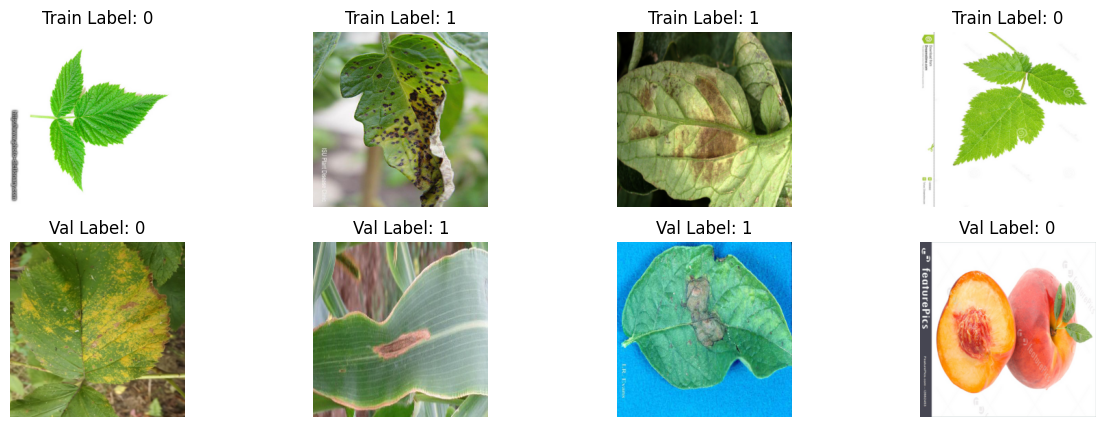

In [ ]:
df = pd.read_csv('/train.csv')
df_train,df_val=train_test_split(df,test_size=0.2,train_size=0.8,stratify=df['binary_pred'])

#Splitting the data frame into df_train, df_val dataframe 80-20 ratio

# Define transformations
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.crop((0, 0, x.width // 2, x.height))),
   transforms.ToTensor(),           # Convert to tensor
])

val_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.crop((0, 0, x.width // 2, x.height))),
   transforms.ToTensor(),           # Convert to tensor
])

#Weights0,Weights1=df_train['binary_pred'].value_counts(normalize=True)

# Initialize custom dataset
train_dataset = PlantDataset(df_train,
                        root_dir='/train/train',
                        transform=train_transform)


val_dataset = PlantDataset(df_val,
                        root_dir='/train/train',
                        transform=val_transform)

# Access dataset samples Write train_dataset for train and val_Dataset for test
# Plot the first four images
fig, axes = plt.subplots(2, 4, figsize=(15, 5))


for i in range(4):
    image, label = train_dataset[i]
    axes[0,i].imshow(image.permute(1, 2, 0))  # Convert tensor to numpy array and change dimension order
    axes[0,i].set_title('Train Label: {}'.format(label))
    axes[0,i].axis('off')
    
    image, label = val_dataset[i]
    axes[1,i].imshow(image.permute(1,2,0))
    axes[1,i].set_title('Val Label: {}'.format(label))
    axes[1,i].axis('off')

plt.show()

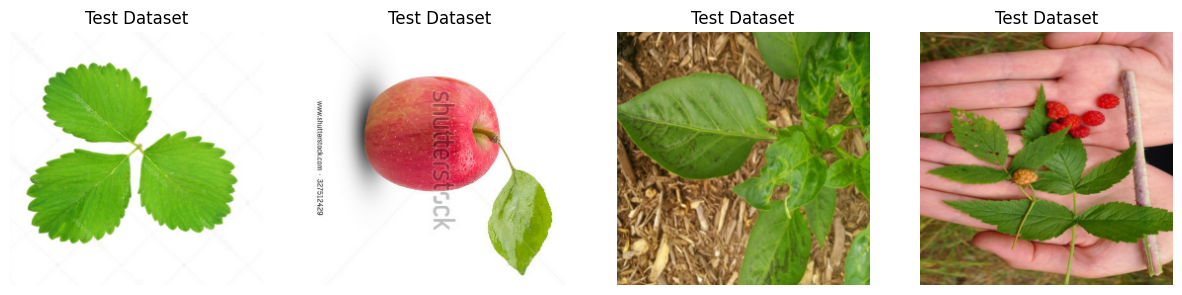

In [ ]:
#For Test Dataset
test_dataset=PlantDatasetTest('/test/test',transform=transforms.ToTensor())

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    image = test_dataset[i]
    axes[i].imshow(image.permute(1, 2, 0))  # Convert tensor to numpy array and change dimension order
    axes[i].set_title('Test Dataset')
    axes[i].axis('off')

plt.show()

In [36]:
#train_data_loader and val_data_loader and testIdata_loader
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_data_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [37]:
# Load pre-trained ResNet model
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a binary classifier
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512,1),
)


# Define loss function and optimizer
resnetLoss_criterion = nn.BCEWithLogitsLoss() #Loss 
optimizer = optim.Adam(resnet.fc.parameters()) #Optimizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnetLoss_criterion = resnetLoss_criterion.to(device)
resnet = resnet.to(device)

print("Using Device: ",device)

Using Device:  cuda


In [38]:
num_epochs = 20
early_stopping_patience = 1  # Number of epochs to wait before early stopping
best_val_loss = float('inf')
no_improvement_count = 0

train_losses = []
val_losses = []
precisions = []
recalls = []
f1_scores = []

for epoch in range(num_epochs):

    resnet.train()

    train_loss = 0.0
    correct_train = 0
    total_train = 0
    tp_train = 0
    fp_train = 0
    fn_train = 0

    for i, (images, labels) in enumerate(train_data_loader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = resnet(images)
        loss = resnetLoss_criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

        predicted = torch.round(torch.sigmoid(outputs)).squeeze(1)
        tp_train += ((predicted == 1) & (labels == 1)).sum().item()
        fp_train += ((predicted == 1) & (labels == 0)).sum().item()
        fn_train += ((predicted == 0) & (labels == 1)).sum().item()

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss /= len(train_data_loader)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train

    precision_train = tp_train / (tp_train + fp_train + 1e-10)  # Adding a small epsilon to avoid division by zero
    recall_train = tp_train / (tp_train + fn_train + 1e-10)
    f1_train = 2 * (precision_train * recall_train) / (precision_train + recall_train + 1e-10)

    resnet.eval()

    val_loss = 0.0
    correct_val = 0
    total_val = 0
    tp_val = 0
    fp_val = 0
    fn_val = 0

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_data_loader):

            images = images.to(device)
            labels = labels.to(device)

            outputs = resnet(images)

            loss = resnetLoss_criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()

            predicted = torch.round(torch.sigmoid(outputs)).squeeze(1)
            tp_val += ((predicted == 1) & (labels == 1)).sum().item()
            fp_val += ((predicted == 1) & (labels == 0)).sum().item()
            fn_val += ((predicted == 0) & (labels == 1)).sum().item()

            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

        val_loss /= len(val_data_loader)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val

        precision_val = tp_val / (tp_val + fp_val + 1e-10)  # Adding a small epsilon to avoid division by zero
        recall_val = tp_val / (tp_val + fn_val + 1e-10)
        f1_val = 2 * (precision_val * recall_val) / (precision_val + recall_val + 1e-10)

    print('Epoch: {}/{} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tTraining Precision: {:.6f} \tTraining Recall: {:.6f} \tTraining F1: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f} \tValidation Precision: {:.6f} \tValidation Recall: {:.6f} \tValidation F1: {:.6f}'.format(epoch+1, num_epochs,train_loss, train_accuracy, precision_train, recall_train, f1_train, val_loss, val_accuracy, precision_val, recall_val, f1_val))
    precisions.append(precision_val)
    recalls.append(recall_val)
    f1_scores.append(f1_val)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        if no_improvement_count >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1} as validation loss did not improve for {early_stopping_patience} epochs.')
            break  # Stop training loop


Epoch: 1/20 	Training Loss: 0.261535 	Training Accuracy: 0.900680 	Training Precision: 0.881844 	Training Recall: 0.905325 	Training F1: 0.893431 	Validation Loss: 0.195358 	Validation Accuracy: 0.918478 	Validation Precision: 0.972973 	Validation Recall: 0.847059 	Validation F1: 0.905660
Epoch: 2/20 	Training Loss: 0.083082 	Training Accuracy: 0.972789 	Training Precision: 0.973214 	Training Recall: 0.967456 	Training F1: 0.970326 	Validation Loss: 0.112844 	Validation Accuracy: 0.956522 	Validation Precision: 0.975309 	Validation Recall: 0.929412 	Validation F1: 0.951807
Epoch: 3/20 	Training Loss: 0.043008 	Training Accuracy: 0.991837 	Training Precision: 0.994048 	Training Recall: 0.988166 	Training F1: 0.991098 	Validation Loss: 0.109528 	Validation Accuracy: 0.956522 	Validation Precision: 0.975309 	Validation Recall: 0.929412 	Validation F1: 0.951807
Epoch: 4/20 	Training Loss: 0.058792 	Training Accuracy: 0.979592 	Training Precision: 0.979228 	Training Recall: 0.976331 	Traini

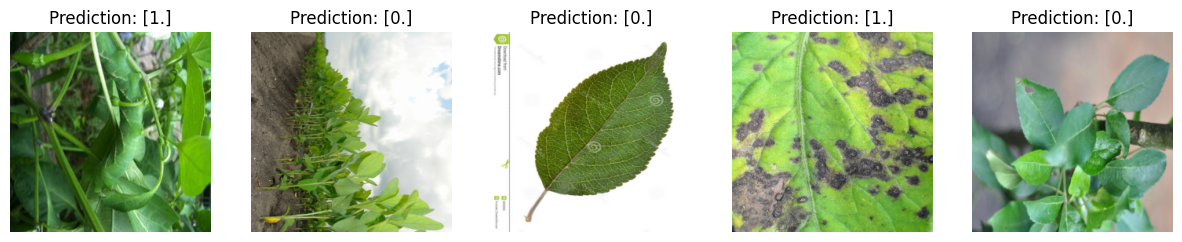

In [65]:
# Set model to evaluation mode
resnet.eval()

# Use torch.no_grad() to disable gradient calculation during inference
with torch.no_grad():
    for images in test_data_loader:
        images = images.to(device)
        #print(images.shape) #(16,3,256,256)
        # print(len(images)) #16 last one is of size 10
        
        # Forward pass
        outputs = resnet(images)
        #print(len(test_data_loader)) #25
        
        # Convert outputs to probabilities and get predicted labels
        predicted = torch.round(torch.sigmoid(outputs))
        
        # Convert images and predictions to numpy arrays
        images_np = images.cpu().numpy()
        predictions_np = predicted.cpu().numpy()
        

fig , axes =plt.subplots(1,5,figsize=(15,5))

for i,j in enumerate(np.random.randint(0,len(images_np),5)):
    # print(images_np[i].shape) (3,256,256)
    image=np.transpose(images_np[j],(1,2,0))
    axes[i].imshow(image)
    axes[i].set_title('Prediction: {}'.format(predictions_np[j]))
    axes[i].axis('off')

plt.show()

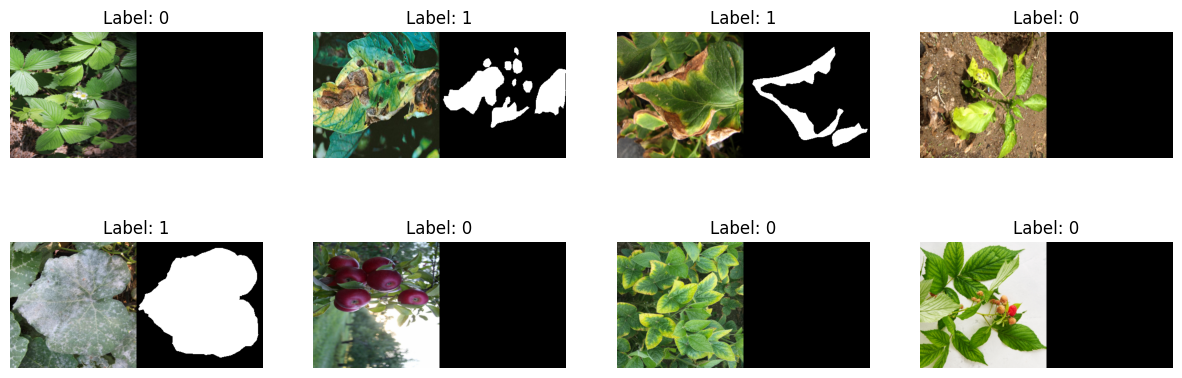

In [ ]:
df_train_label1 = df_train[df_train['binary_pred'] == 1]
df_train_label0 = df_train[df_train['binary_pred'] == 0]


df_val_label1 = df_val[df_val['binary_pred'] == 1]
df_val_label0 = df_val[df_val['binary_pred'] == 0]

# Initialize custom datasets for each label
#train_dataset_label1 = PlantDataset(df_train_label1,
#                                    root_dir='/kaggle/input/mlds-assignment-2/train/train',
#                                    transform=transforms.ToTensor())
#train_dataset_label0 = PlantDataset(df_train_label0,
#                                    root_dir='/kaggle/input/mlds-assignment-2/train/train',
#                                    transform=transforms.ToTensor())
#
#train_segment_data=PlantDataset(df_train,root_dir='/kaggle/input/mlds-assignment-2/train/train',transform=transforms.ToTensor())

df_seg = pd.read_csv('2/train.csv')
df_segtrain,df_segval=train_test_split(df_seg,test_size=0.2,train_size=0.8,stratify=df['binary_pred'])
train_segment_data=PlantDataset(df_segtrain,root_dir='/train/train',transform=transforms.ToTensor())
val_segment_data=PlantDataset(df_segval,root_dir='/train/train',transform=transforms.ToTensor())


#val_dataset_label1 = PlantDataset(df_val_label1,
#                                  root_dir='/kaggle/input/mlds-assignment-2/train/train',
#                                  transform=transforms.ToTensor())
#val_dataset_label0 = PlantDataset(df_val_label0,
#                                  root_dir='/kaggle/input/mlds-assignment-2/train/train',
#                                  transform=transforms.ToTensor())

# Access dataset samples and plot the first four images for each label
fig, axes = plt.subplots(2, 4, figsize=(15, 5))

# Plot for label 1
for i in range(4):
    image, label = train_segment_data[i]
    axes[0, i].imshow(image.permute(1, 2, 0))  # Convert tensor to numpy array and change dimension order
    axes[0, i].set_title('Label: {}'.format(label))
    axes[0, i].axis('off')

# Plot for label 0

for i in range(4):
    image, label = val_segment_data[i]
    axes[1, i].imshow(image.permute(1, 2, 0))  # Convert tensor to numpy array and change dimension order
    axes[1, i].set_title('Label: {}'.format(label))
    axes[1, i].axis('off')

plt.show()

In [72]:
class SplitImages(Dataset):
    def __init__(self, dataset, transform=None):
        """
        Args:
            dataset (Dataset): PyTorch Dataset object containing images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_full, _ = self.dataset[idx]  # Ignore the label

        # Split the image along the width
        mid_width = image_full.shape[2] // 2
        image = image_full[:, :, :mid_width]
        mask = image_full[:, :, mid_width:]

        # Select the first channel of the mask
        mask = mask[0, :, :].unsqueeze(0)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [73]:
# Initialize the SplitImages dataset without the transforms.ToTensor() transform
#train_segmentation_dataset = SplitImages(train_dataset_label1)
#val_segmentation_dataset = SplitImages(val_dataset_label1)

train_segmentation_dataset=SplitImages(train_segment_data)
val_segmentation_dataset=SplitImages(val_segment_data)

# Create a validation data loader
train_segmentation_loader=torch.utils.data.DataLoader(train_segmentation_dataset,batch_size=16,shuffle=True)
val_segmentation_loader = torch.utils.data.DataLoader(val_segmentation_dataset, batch_size=16, shuffle=False)

Training Data set for Segmentation: 


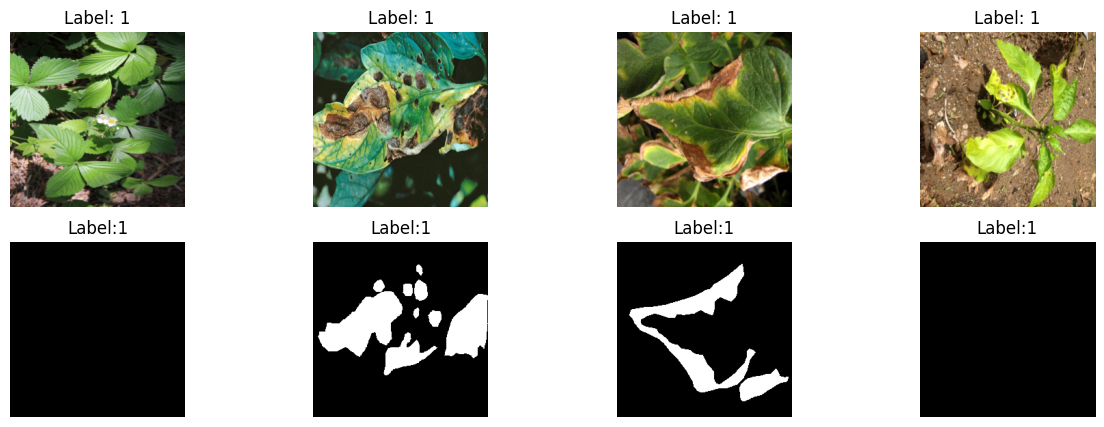

In [74]:
# Access dataset samples and plot the first four images for each label
fig, axes = plt.subplots(2, 4, figsize=(15, 5))

# Plot for label 1
print("Training Data set for Segmentation: ")
for i in range(4):
    image, mask = train_segmentation_dataset[i]
    axes[0, i].imshow(image.permute(1, 2, 0))  # Convert tensor to numpy array and change dimension orde
    axes[0, i].set_title('Label: 1')
    axes[0, i].axis('off')

    axes[1, i].imshow(mask.permute(1, 2, 0),cmap='gray')  # Convert tensor to numpy array and change dimension order
    axes[1, i].set_title('Label:1')
    axes[1, i].axis('off')

plt.show()

Validation Data Set for Segmentation


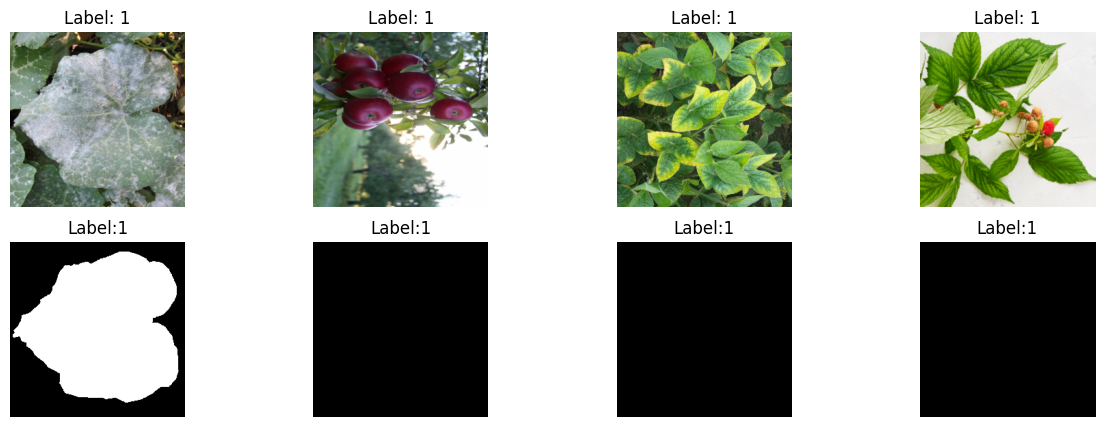

In [75]:
print("Validation Data Set for Segmentation")
fig, axes = plt.subplots(2, 4, figsize=(15, 5))
for i in range(4):
    image, mask = val_segmentation_dataset[i]
    axes[0, i].imshow(image.permute(1, 2, 0))  # Convert tensor to numpy array and change dimension order
    axes[0, i].set_title('Label: 1')
    axes[0, i].axis('off')
    axes[1, i].imshow(mask.permute(1, 2, 0),cmap='gray')  # Convert tensor to numpy array and change dimension order
    axes[1, i].set_title('Label:1')
    axes[1, i].axis('off')

plt.show()

In [76]:
def calculate_accuracy(outputs, masks):
    # Convert the outputs and masks to binary
    outputs_bin = (outputs > 0.5).float()
    masks_bin = (masks > 0.5).float()
    
    #print(outputs_bin.shape) masks_bin and outputs_bin must be of same shape 3*256*256

    # Calculate the accuracy
    accuracy = accuracy_score(masks_bin.flatten().cpu().numpy(), outputs_bin.flatten().cpu().numpy())

    return accuracy

In [77]:
unet = UnetPlusPlus(encoder_name='resnet18', encoder_weights='imagenet', classes=1)

# Define the loss functions and optimizer
unetLoss_criterion_tversky = DiceLoss(mode='binary')
#unetLoss_criterion_bce = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet.parameters(), weight_decay=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet = unet.to(device)
print("Using Device: ", device)
unetLoss_criterion_tversky = unetLoss_criterion_tversky.to(device)
unetLoss_criterion_bce = unetLoss_criterion_bce.to(device)


Using Device:  cuda


In [79]:
# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    
    unet.train()
    train_accuracy = 0
    train_loss = 0
    train_tp = 0
    train_fp = 0
    train_fn = 0

    for images, masks in train_segmentation_loader:
        
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = unet(images)
        loss_tversky = unetLoss_criterion_tversky(outputs, masks)
        #loss_bce = unetLoss_criterion_bce(outputs, masks)

        # Combine losses
        alpha = 1  # You can adjust this weight according to your preference
        loss = alpha * loss_tversky #+ (1 - alpha) * loss_bce

        # Calculate accuracy
        train_accuracy += calculate_accuracy(outputs, masks)

        # Accumulate loss
        train_loss += loss.item()

        # Calculate true positives, false positives, and false negatives
        outputs = (outputs > 0.5).float()
        tp = torch.sum(outputs * masks)
        fp = torch.sum(outputs) - tp
        fn = torch.sum(masks) - tp

        train_tp += tp.item()
        train_fp += fp.item()
        train_fn += fn.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average training accuracy
    train_accuracy /= len(train_segmentation_loader)
    train_loss /= len(train_segmentation_loader)

    # Calculate Dice score
    dice_score_train = 2 * train_tp / (2 * train_tp + train_fp + train_fn + 1e-10)

    # Evaluate on validation data
    unet.eval()

    val_accuracy = 0
    val_loss = 0
    val_tp = 0
    val_fp = 0
    val_fn = 0
    
    with torch.no_grad():
        for images, masks in val_segmentation_loader:

            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = unet(images)

            loss_tversky = unetLoss_criterion_tversky(outputs, masks)
            #loss_bce = unetLoss_criterion_bce(outputs, masks)

            # Combine losses
            #val_loss += alpha * loss_tversky + (1 - alpha) * loss_bce
            val_loss+=loss_tversky

            # Convert the outputs to binary
            outputs = (outputs > 0.5).float()

            # Calculate accuracy
            val_accuracy += calculate_accuracy(outputs, masks)

            # Calculate true positives, false positives, and false negatives
            tp = torch.sum(outputs * masks)
            fp = torch.sum(outputs) - tp
            fn = torch.sum(masks) - tp

            val_tp += tp.item()
            val_fp += fp.item()
            val_fn += fn.item()

    # Calculate average validation accuracy
    val_accuracy /= len(val_segmentation_loader)
    val_loss /= len(val_segmentation_loader)

    # Calculate Dice score
    dice_score_val = 2 * val_tp / (2 * val_tp + val_fp + val_fn + 1e-10)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}, Train Dice Score: {dice_score_train}, Val Dice Score: {dice_score_val}')


Epoch 1/10, Train Loss: 0.39287088357883954, Val Loss: 0.4391882121562958, Train Accuracy: 0.9404606639475063, Val Accuracy: 0.936177651087443, Train Dice Score: 0.6188617124605462, Val Dice Score: 0.5426200717611256
Epoch 2/10, Train Loss: 0.3722549210424009, Val Loss: 0.534488320350647, Train Accuracy: 0.9439742198888806, Val Accuracy: 0.9408667087554932, Train Dice Score: 0.6400342117815423, Val Dice Score: 0.44202432677834724
Epoch 3/10, Train Loss: 0.35009860344555066, Val Loss: 0.7158263921737671, Train Accuracy: 0.9477481441221376, Val Accuracy: 0.9309466679890951, Train Dice Score: 0.6586671227595793, Val Dice Score: 0.2455700034496596
Epoch 4/10, Train Loss: 0.3411719086377517, Val Loss: 0.3524594306945801, Train Accuracy: 0.949201372395391, Val Accuracy: 0.9294513066609701, Train Dice Score: 0.6648297873069033, Val Dice Score: 0.6613494752005938
Epoch 5/10, Train Loss: 0.36892529933348944, Val Loss: 0.4569784998893738, Train Accuracy: 0.9452334473098533, Val Accuracy: 0.93721

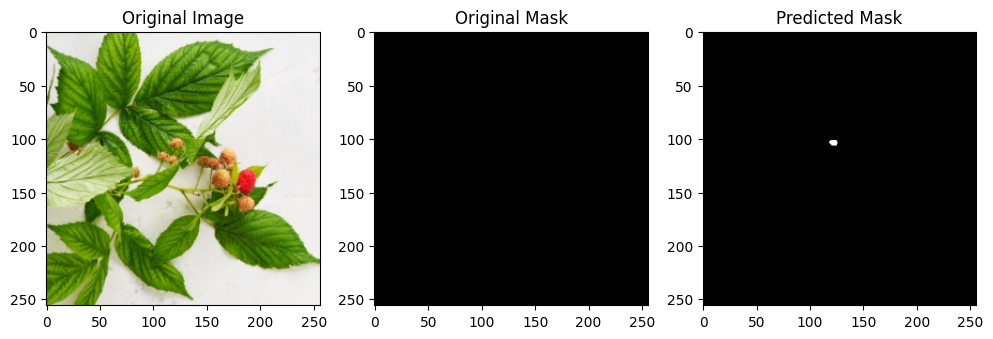

In [80]:
import matplotlib.pyplot as plt

unet.eval()
# Get a batch of validation data
images, masks = next(iter(val_segmentation_loader))

# Move the images and masks to the GPU if available
images = images.to(device)
masks = masks.to(device)

# Get the model's predictions
outputs = unet(images)

# Move the images, masks and outputs to the CPU
images = images.cpu().numpy()
masks = masks.cpu().numpy()
outputs = (outputs>0.5).detach().cpu().numpy()

# Plot the original image, mask and predicted mask for the first image in the batch
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(images[3].transpose((1, 2, 0)))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(masks[3].squeeze(), cmap='gray')
plt.title('Original Mask')

plt.subplot(1, 3, 3)
plt.imshow(outputs[3].squeeze(), cmap='gray')
plt.title('Predicted Mask')

plt.show()

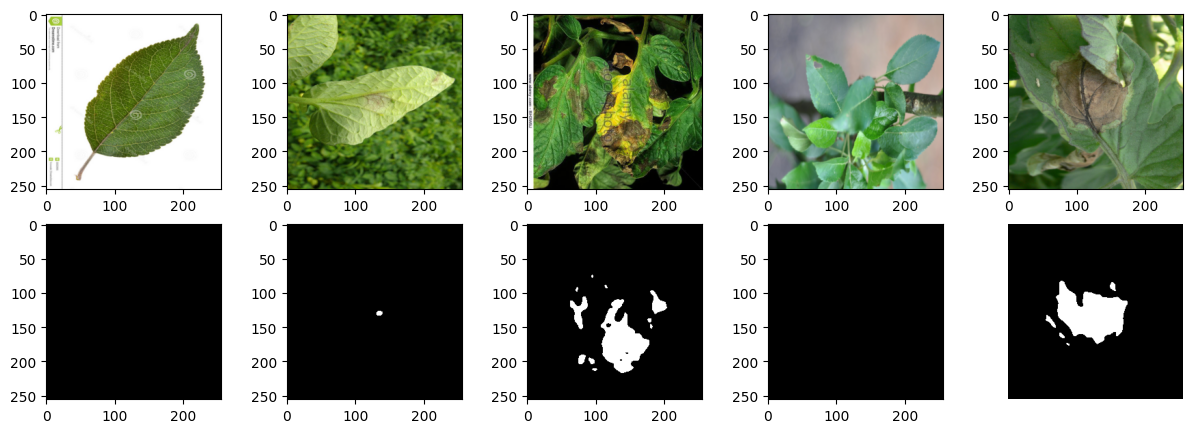

In [81]:
# Set model to evaluation mode
unet.eval()

# Use torch.no_grad() to disable gradient calculation during inference
with torch.no_grad():
    for images in test_data_loader:
        images = images.to(device)
        # Forward pass
        outputs = unet(images)
        
        # Convert outputs to probabilities and get predicted labels
        predicted = torch.round(torch.sigmoid(outputs))
        
        # Convert images and predictions to numpy arrays
        images_np = images.cpu().numpy()
        predictions_np =predicted.cpu().numpy()
        
        # Plot images and predictions
fig,axes=plt.subplots(2,5,figsize=(15,5))
for i in range(5):
    axes[0,i].imshow(images_np[i].transpose(1,2,0))
    axes[1,i].imshow(predictions_np[i].transpose(1,2,0),cmap='gray')
    plt.axis('off')
plt.show()

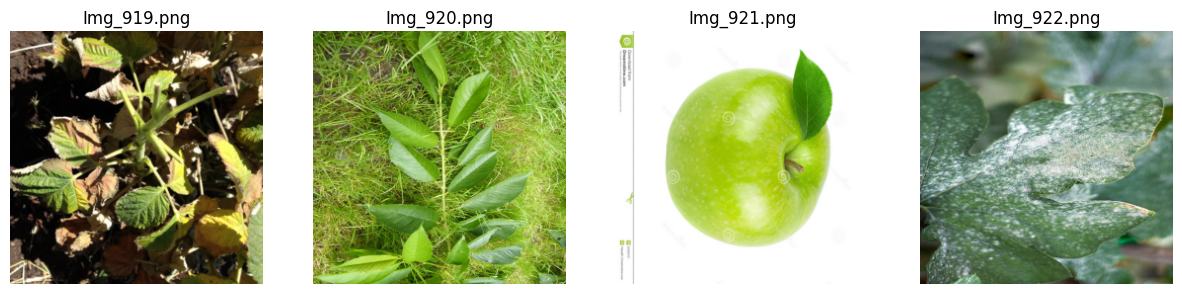

In [ ]:
df_test=pd.read_csv('/test.csv')
test_images=[]

for i in range(len(df_test)):
    image = np.array(Image.open('/test/test/' + df_test['id'][i]).convert('RGB'))
    test_images.append(image)
test_images = np.array(test_images)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(test_images[i])
    axes[i].set_title(df_test['id'][i])
    axes[i].axis('off')
plt.show()

In [83]:
class TestImagesDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        return image

# Create the dataset
test_dataset = TestImagesDataset(test_images, transform=transforms.ToTensor())

# Create the DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [84]:
resnet.eval()
unet.eval()
df_test['segmentation_pred'] = df_test['segmentation_pred'].astype(str)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = resnet.to(device)
unet = unet.to(device)

print("Using Device: ",device)

with torch.no_grad():
    i=0
    for image in test_loader:
        
        image = image.to(device)
        # print(image.shape) 1,3,256,256
        
        output = resnet(image)
        # print(output.shape) 1,1
        
        prediction = torch.round(torch.sigmoid(output))

        if (prediction == 0):
            df_test.loc[i,'binary_pred'] = 0
            df_test.loc[i,'segmentation_pred'] = 'Healthy'
        elif (prediction == 1):
            
            df_test.loc[i,'binary_pred'] = 1
            
            mask=unet(image)
            # print(output.shape) 1,1,256,256
            
            mask=mask.cpu()
            mask=(mask>0.5).float()
            # print(mask.shape) # 1,1,256,256
            
            #Remove the channel dimension
            mask=mask.squeeze(0)
            mask=mask.squeeze(0)
            # print(mask.shape) # 256,256
            #now Stack the mask dimension
            mask_3d=torch.stack((mask,mask,mask),dim=0)
            # print(mask_3d.shape) # 3,256,256
            if mask2rle(np.transpose(mask_3d,(1,2,0)))=='':
                df_test.loc[i,'segmentation_pred']='Healthy'
            else:
                df_test.loc[i,'segmentation_pred'] = mask2rle(np.transpose(mask_3d,(1,2,0)))
        i+=1


Using Device:  cuda


/tmp/ipykernel_34/2750512979.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3614.)
  pixels= img.T.flatten()


In [ ]:
df_test.to_csv('/submission.csv',index=False)